In [2]:
from collections import deque
from dataclasses import dataclass

import numpy as np
from enum import IntEnum

np.set_printoptions(precision=2)


EXIT = 100
OBSTACLE = -1
EMPTY = 0

In [37]:
class ORIENTATION(IntEnum):
    NORTH = 0
    EAST = 1
    SOUTH = 2
    WEST = 3

    def __repr__(self):
        return self.name

    def heading(self):
        if self == ORIENTATION.NORTH:
            return [0, 1]
        if self == ORIENTATION.EAST:
            return [1, 0]
        if self == ORIENTATION.SOUTH:
            return [0, -1]
        if self == ORIENTATION.WEST:
            return [-1, 0]

    def twist(self, start, goal):
        # use start as origin (0, 0) for goal
        goal = [goal[0] - start[0], goal[1] - start[1]]
        # select normal heading vector
        start = self.heading()
        dot = start[0] * goal[0] + start[1] * goal[1]
        det = start[0] * goal[1] - start[1] * goal[0]
        # rad is in [-pi, pi]
        rad = np.arctan2(det, dot)
        # straight move and diagonal stride to left or right
        if -np.pi / 4 <= rad <= np.pi / 4:
            return self, 0
        # turn right
        if -3 * np.pi / 4 < rad < - np.pi / 4:
            return self.shift(1), 1
        # turn around
        if rad >= 3 * np.pi / 4 or -3 * np.pi / 4 >= rad:
            return self.shift(2), 2
        # turn left
        # if 3 * np.pi / 4 > rad > np.pi / 4:
        return self.shift(3), 3

    def shift(self, shift):
        values = [self.NORTH, self.EAST, self.SOUTH, self.WEST]
        return values[(self + shift) % len(values)]

In [38]:

def possible_moves():
    X = np.array([-1, 0, 1])
    Y = np.array([-1, 0, 1])
    positions = {}
    offset = [(x, y) for x in X for y in Y]
    origin = (0, 0)
    for orientation in ORIENTATION:
        positions[orientation] = []

    # moore neighbourhood
    for orientation in ORIENTATION:
        for cell in offset:
            next_orientation, shift = orientation.twist(origin, cell)
            positions[orientation].append((cell, next_orientation))

    # turning maneuver
    for orientation in ORIENTATION:
        if orientation == ORIENTATION.NORTH or orientation == ORIENTATION.SOUTH:
            cell, next_orientation = (2, 1), ORIENTATION.EAST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-2, 1), ORIENTATION.EAST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (2, -1), ORIENTATION.WEST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-2, -1), ORIENTATION.WEST
            positions[orientation].append((cell, next_orientation))
        if orientation == ORIENTATION.EAST or orientation == ORIENTATION.WEST:
            cell, next_orientation = (1, 2), ORIENTATION.NORTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, 2), ORIENTATION.NORTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (1, -2), ORIENTATION.SOUTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, -2), ORIENTATION.SOUTH
            positions[orientation].append((cell, next_orientation))

    # rotation in place
    for orientation in ORIENTATION:
        for next_orientation in ORIENTATION:
            cell, next_orientation = origin, next_orientation
            positions[orientation].append((cell, next_orientation))
        # remove duplicate (0, 0), orientation
        del positions[orientation][positions[orientation].index((origin, orientation))]

    # partner rotates, this agent follows suite
    for orientation in ORIENTATION:
        if orientation == ORIENTATION.NORTH or orientation == ORIENTATION.SOUTH:
            cell, next_orientation = (1, 1), ORIENTATION.EAST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (1, -1), ORIENTATION.EAST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, 1), ORIENTATION.WEST
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, -1), ORIENTATION.WEST
            positions[orientation].append((cell, next_orientation))
        if orientation == ORIENTATION.WEST or orientation == ORIENTATION.EAST:
            cell, next_orientation = (1, 1), ORIENTATION.NORTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, 1), ORIENTATION.NORTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (1, -1), ORIENTATION.SOUTH
            positions[orientation].append((cell, next_orientation))
            cell, next_orientation = (-1, -1), ORIENTATION.SOUTH
            positions[orientation].append((cell, next_orientation))
    return positions


def expand_moves():
    partner = possible_moves()
    partner_offset = [
        # NORTH
        (1, 0),
        # EAST
        (0, -1),
        # SOUTH
        (-1, 0),
        # WEST
        (0, 1)]
    for orientation in ORIENTATION:
        offset_positions = []
        for partner_move in partner[orientation]:
            partner_position, next_orientation = partner_move
            offset_position = partner_position[0] + partner_offset[orientation][0], \
                              partner_position[1] + partner_offset[orientation][1]
            offset_positions.append((offset_position, next_orientation))
        partner[orientation] = offset_positions
    return partner


def valid_position(combination):
    LEADER = 0
    PARTNER = 1
    POSITION = 0
    ORIENTATION_VALUE = 1
    leader, partner = combination
    if leader[ORIENTATION_VALUE] == ORIENTATION.NORTH or leader[ORIENTATION_VALUE] == ORIENTATION.SOUTH:
        side1 = leader[POSITION][0] - 1, leader[POSITION][1]
        side2 = leader[POSITION][0] + 1, leader[POSITION][1]
        if partner[POSITION] == side1 or partner[POSITION] == side2:
            return True
    if leader[ORIENTATION_VALUE] == ORIENTATION.EAST or leader[ORIENTATION_VALUE] == ORIENTATION.WEST:
        side1 = leader[POSITION][0], leader[POSITION][1] - 1
        side2 = leader[POSITION][0], leader[POSITION][1] + 1
        if partner[POSITION] == side1 or partner[POSITION] == side2:
            return True
    return False


def connected(combination):
    leader, partner = combination
    norm = np.abs(leader[0][0] - partner[0][0]) + np.abs(leader[0][1] - partner[0][1])
    return norm == 1


def combine(orientation):
    LEADER = 0
    PARTNER = 1
    POSITION = 0
    ORIENTATION_VALUE = 1
    leader_positions = possible_moves()[orientation]
    partner_positions = expand_moves()[orientation]
    leader_partner = [(l, p) for l in leader_positions for p in partner_positions]

    # leader and partner in the same position
    print("ALL:", len((leader_partner)))
    leader_partner = list(filter(lambda lp: lp[LEADER][POSITION] != lp[PARTNER][POSITION], leader_partner))
    print("Different position:", len((leader_partner)))

    # leader and partner are separated
    leader_partner = list(filter(connected, leader_partner))
    print("Connected:", len((leader_partner)))

    # leader and partner are aligned side by side
    leader_partner = list(filter(valid_position, leader_partner))
    print("Side by side:", len((leader_partner)))

    # leader and partner have same direction
    print(len(leader_partner))
    different_dir = list(
        filter(lambda lp: lp[LEADER][ORIENTATION_VALUE] != lp[PARTNER][ORIENTATION_VALUE], leader_partner))
    print("DIR", different_dir)

    # leader and partner don't have same direction
    print(len(leader_partner))
    leader_partner = list(
        filter(lambda lp: lp[LEADER][ORIENTATION_VALUE] == lp[PARTNER][ORIENTATION_VALUE], leader_partner))

    # leader and partner are aligned side by side
    print(len((leader_partner)))
    leader_partner = list(filter(valid_position, leader_partner))
    print(len((leader_partner)))
    return leader_partner


def maneuvers():
    maneuvers = {}
    for orientation in ORIENTATION:
        maneuvers[orientation] = combine(orientation)
    return maneuvers


MANEUVERS = maneuvers()

ALL: 400
Different position: 376
Connected: 93
Side by side: 46
46
DIR [(((-1, -1), SOUTH), ((0, -1), WEST)), (((-1, 0), WEST), ((-1, 1), EAST)), (((-1, 1), NORTH), ((0, 1), WEST)), (((0, -1), SOUTH), ((-1, -1), WEST)), (((0, 1), NORTH), ((-1, 1), EAST)), (((1, -1), SOUTH), ((2, -1), EAST)), (((1, -1), SOUTH), ((0, -1), WEST)), (((1, 0), EAST), ((1, -1), SOUTH)), (((1, 0), EAST), ((1, 1), NORTH)), (((1, 1), NORTH), ((2, 1), EAST)), (((1, 1), NORTH), ((0, 1), WEST)), (((2, -1), WEST), ((2, 0), EAST)), (((0, 0), NORTH), ((1, 0), EAST)), (((0, 0), NORTH), ((1, 0), SOUTH)), (((0, 0), NORTH), ((1, 0), WEST)), (((0, 0), EAST), ((0, -1), SOUTH)), (((0, 0), EAST), ((0, 1), NORTH)), (((0, 0), EAST), ((0, 1), WEST)), (((0, 0), EAST), ((0, -1), WEST)), (((0, 0), SOUTH), ((1, 0), NORTH)), (((0, 0), SOUTH), ((1, 0), EAST)), (((0, 0), SOUTH), ((1, 0), WEST)), (((0, 0), WEST), ((0, -1), SOUTH)), (((0, 0), WEST), ((0, 1), NORTH)), (((1, 1), EAST), ((1, 0), NORTH)), (((1, 1), EAST), ((1, 0), SOUTH)), (

In [40]:
leader = possible_moves()
partner = expand_moves()
print(leader[0])
print(partner[0])

[((-1, -1), SOUTH), ((-1, 0), WEST), ((-1, 1), NORTH), ((0, -1), SOUTH), ((0, 1), NORTH), ((1, -1), SOUTH), ((1, 0), EAST), ((1, 1), NORTH), ((2, 1), EAST), ((-2, 1), EAST), ((2, -1), WEST), ((-2, -1), WEST), ((0, 0), NORTH), ((0, 0), EAST), ((0, 0), SOUTH), ((0, 0), WEST), ((1, 1), EAST), ((1, -1), EAST), ((-1, 1), WEST), ((-1, -1), WEST)]
[((0, -1), SOUTH), ((0, 0), WEST), ((0, 1), NORTH), ((1, -1), SOUTH), ((1, 1), NORTH), ((2, -1), SOUTH), ((2, 0), EAST), ((2, 1), NORTH), ((3, 1), EAST), ((-1, 1), EAST), ((3, -1), WEST), ((-1, -1), WEST), ((1, 0), NORTH), ((1, 0), EAST), ((1, 0), SOUTH), ((1, 0), WEST), ((2, 1), EAST), ((2, -1), EAST), ((0, 1), WEST), ((0, -1), WEST)]


In [35]:
maneuvers = {}
for orientation in ORIENTATION:
    print(orientation)
    maneuvers[orientation] = combine(orientation)
    print(maneuvers[orientation])

ORIENTATION.NORTH
ALL: 400
Different position: 376
Connected: 93
Side by side: 46
46
DIR [(((-1, -1), SOUTH), ((0, -1), WEST)), (((-1, 0), WEST), ((-1, 1), EAST)), (((-1, 1), NORTH), ((0, 1), WEST)), (((0, -1), SOUTH), ((-1, -1), WEST)), (((0, 1), NORTH), ((-1, 1), EAST)), (((1, -1), SOUTH), ((2, -1), EAST)), (((1, -1), SOUTH), ((0, -1), WEST)), (((1, 0), EAST), ((1, -1), SOUTH)), (((1, 0), EAST), ((1, 1), NORTH)), (((1, 1), NORTH), ((2, 1), EAST)), (((1, 1), NORTH), ((0, 1), WEST)), (((2, -1), WEST), ((2, 0), EAST)), (((0, 0), NORTH), ((1, 0), EAST)), (((0, 0), NORTH), ((1, 0), SOUTH)), (((0, 0), NORTH), ((1, 0), WEST)), (((0, 0), EAST), ((0, -1), SOUTH)), (((0, 0), EAST), ((0, 1), NORTH)), (((0, 0), EAST), ((0, 1), WEST)), (((0, 0), EAST), ((0, -1), WEST)), (((0, 0), SOUTH), ((1, 0), NORTH)), (((0, 0), SOUTH), ((1, 0), EAST)), (((0, 0), SOUTH), ((1, 0), WEST)), (((0, 0), WEST), ((0, -1), SOUTH)), (((0, 0), WEST), ((0, 1), NORTH)), (((1, 1), EAST), ((1, 0), NORTH)), (((1, 1), EAST), (

In [15]:
a = maneuvers[ORIENTATION.NORTH]
b = maneuvers[ORIENTATION.EAST]
aset = set()
bset = set()
for i in range(len(a)):
    print(a[i])
    print(b[i], "\n")
    aset.add(a[i])
    bset.add(b[i])
print(b[16])
print(b[17], "\n")
bset.add(b[16])
bset.add(b[17])

print("difference", aset.difference(bset))
aonly = aset.symmetric_difference(bset)
for item in aonly:
    print(item)

(((-1, -1), SOUTH), ((0, -1), SOUTH))
(((-1, -1), WEST), ((-1, -2), WEST)) 

(((-1, 0), WEST), ((-1, -1), WEST))
(((-1, -1), WEST), ((-1, 0), WEST)) 

(((-1, 1), NORTH), ((0, 1), NORTH))
(((-1, 0), WEST), ((-1, -1), WEST)) 

(((0, -1), SOUTH), ((1, -1), SOUTH))
(((-1, 1), WEST), ((-1, 0), WEST)) 

(((0, 1), NORTH), ((1, 1), NORTH))
(((0, 1), NORTH), ((1, 1), NORTH)) 

(((1, -1), SOUTH), ((0, -1), SOUTH))
(((0, 1), NORTH), ((-1, 1), NORTH)) 

(((1, -1), SOUTH), ((2, -1), SOUTH))
(((1, -1), EAST), ((1, -2), EAST)) 

(((1, 1), NORTH), ((0, 1), NORTH))
(((1, -1), EAST), ((1, 0), EAST)) 

(((1, 1), NORTH), ((2, 1), NORTH))
(((1, 0), EAST), ((1, -1), EAST)) 

(((2, 1), EAST), ((2, 0), EAST))
(((1, 1), EAST), ((1, 0), EAST)) 

(((0, 0), NORTH), ((1, 0), NORTH))
(((1, -2), SOUTH), ((0, -2), SOUTH)) 

(((0, 0), SOUTH), ((1, 0), SOUTH))
(((-1, -2), SOUTH), ((0, -2), SOUTH)) 

(((0, 0), WEST), ((0, 1), WEST))
(((0, 0), NORTH), ((1, 0), NORTH)) 

(((0, 0), WEST), ((0, -1), WEST))
(((0, 0), NORTH),

In [ ]:
print(len(maneuvers[0]))
print(maneuvers[0])
print(maneuvers[0][2][0][1])

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_orientations(maneuvers):
    scale = 0.25
    arrows = {orientation: orientation.heading() for orientation in ORIENTATION}
    arrows[-1] = (0, 0)
    n = 6
    offset = n // 2
    ar = [[-1]*n for _ in range(n)]
    idx = 0
    for i in range(n):
        for j in range(n):
            x, y = maneuvers[idx][0][0]
            orientation = maneuvers[idx][0][1]
            ar[y+offset][x+offset] = orientation
            idx += 1
            if idx >= len(maneuvers):
                break
        if idx >= len(maneuvers):
            break
    fig, ax = plt.subplots(figsize=(6, 6))
    for r, row in enumerate(ar):
        for c, cell in enumerate(row):
            plt.arrow(c, 5-r, scale*arrows[cell][0], scale*arrows[cell][1], head_width=0.1)
            scale *= 0.95
    plt.show()
    
for maneuver in maneuvers.values():
    plot_orientations(maneuver)

In [39]:
def pair_people(people):
    grid = []
    for i in range(len(people)):
        grid.append([None] * len(people[i]))

    for i in range(len(people)):
        for j in range(len(people[i])):
            if people[i][j] == 1:
                grid[i][j] = (i, j)
    print(grid)

    def get_neighbors(i, j):
        neighbors = []
        if i > 0 and people[i - 1][j] == 1:
            neighbors.append(grid[i - 1][j])
        if i < len(people) - 1 and people[i + 1][j] == 1:
            neighbors.append(grid[i + 1][j])
        if j > 0 and people[i][j - 1] == 1:
            neighbors.append(grid[i][j - 1])
        if j < len(people[i]) - 1 and people[i][j + 1] == 1:
            neighbors.append(grid[i][j + 1])
        return neighbors

    def dfs(person, pairs):
        print(person)
        if person is None:
            return True
        i, j = person
        for neighbor in get_neighbors(i, j):
            ni, nj = neighbor
            if (ni, nj) not in pairs:
                pairs.add((ni, nj))
                if dfs(grid[ni][nj], pairs):
                    grid[i][j] = None
                    return True
                pairs.remove((ni, nj))
        return False

    pairs = set()
    for i in range(len(people)):
        for j in range(len(people[i])):
            if people[i][j] == 1:
                dfs(grid[i][j], pairs)
    return pairs

In [40]:
generate = False
if generate:
    n = 5
    grid = np.ones(shape=(n, 2))
    x = 2
    for sample in range(x):
        i = np.random.randint(n)
        j = np.random.randint(2)
        grid[i, j] = 0
print(grid)
grid2 = [[1, 1]]
print(pair_people(grid2))

[[1. 1.]
 [0. 0.]
 [1. 1.]
 [1. 1.]
 [1. 1.]]
[[(0, 0), (0, 1)]]
(0, 0)
(0, 1)
(0, 0)
(0, 1)
(0, 0)
(0, 1)
set()


In [121]:
def make_graph(grid):
    v = set()
    e = {}
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            e[(i,j)] = set()
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):        
            if grid[i,j] == 0:
                continue
            v.add((i,j))
            ni = i + 1
            nj = j
            if 0 <= ni < grid.shape[0]:
                if grid[ni, nj] == 1:
                    e[(i,j)].add((ni,nj))
                    e[(ni,nj)].add((i,j))
            ni = i - 1
            nj = j
            if 0 <= ni < grid.shape[0]:
                if grid[ni, nj] == 1:
                    e[(i,j)].add((ni,nj))
                    e[(ni,nj)].add((i,j))

            ni = i
            nj = j + 1
            if 0 <= nj < grid.shape[1]:
                if grid[ni, nj] == 1:
                    e[(i,j)].add((ni,nj))
                    e[(ni,nj)].add((i,j))
            ni = i
            nj = j - 1
            if 0 <= nj < grid.shape[1]:
                if grid[ni, nj] == 1:
                    e[(i,j)].add((ni,nj))
                    e[(ni,nj)].add((i,j))
    return v, e

def lower_degrees(v,e):
    deg = []
    for key in e:
        d = len(e[key])
        deg.append((d, key))
    DEGREE = 0
    VORTEX = 1
    TOP = 0
    deg = sorted(deg, key=lambda x: x[DEGREE], reverse=True)
    while deg[TOP][DEGREE] > 1:
        top_vortex = deg[TOP][VORTEX]
        edges = e[top_vortex]
        top_degree, top_edge = sorted([(len(e[edge]), edge) for edge in edges], key=lambda x: x[DEGREE], reverse=True)[TOP]
        e[top_vortex].remove(top_edge)
        e[top_edge].remove(top_vortex)
        deg = []
        for key in e:
            d = len(e[key])
            deg.append((d, key))
        deg = sorted(deg, key=lambda x: x[DEGREE], reverse=True)            
    return v, e

def show_pairs(v, e, grid):
    cnt = 1
    a = np.zeros_like(grid)
    for key in list(v):
        if len(e[key]) > 0:
            i, j = key
            a[i,j] = cnt
            ni, nj = e[key].pop()
            a[ni, nj] = cnt
        cnt += 1
    return a


In [128]:
generate = True
if generate:
    n = 14
    grid = np.ones(shape=(n, n))
    x = 130
    for sample in range(x):
        i = np.random.randint(n)
        j = np.random.randint(n)
        grid[i, j] = 0

print(grid)
v, e = make_graph(grid)
print(v)
v2, e2 = lower_degrees(v,e)
print(show_pairs(v2, e2, grid))

[[0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.]
 [0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0.]]
{(5, 1), (8, 0), (8, 9), (9, 8), (0, 5), (2, 11), (13, 8), (6, 2), (7, 1), (6, 11), (4, 2), (3, 6), (5, 3), (8, 2), (8, 11), (9, 10), (2, 4), (1, 8), (13, 10), (7, 12), (5, 5), (8, 4), (9, 3), (11, 0), (0, 9), (13, 12), (3, 1), (3, 10), (5, 7), (11, 2), (1, 3), (3, 3), (5, 0), (5, 9), (1, 5), (3, 5), (10, 1), (1, 7), (13, 9), (2, 6), (7, 11), (12, 1), (5, 4), (4, 6),

In [1]:
print("hmm")

hmm


In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [13]:
a = [1000+np.random.randint(100) for i in range(10000)]

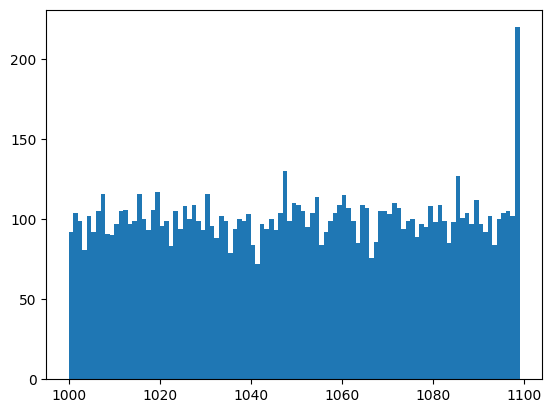

In [12]:
max_a = max(a)
min_a = min(a)
bins = max_a - min_a
fig, ax = plt.subplots()
ax.hist(a, bins=bins)
plt.show()